In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import MCMT

In [2]:
# オラクル
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "oracle"

In [3]:
def initialize_s(qc, qubits):
    """qcの 'qubits' にH-gate を適用"""
    for q in qubits:
        qc.h(q)
    return qc

In [4]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Hゲートで |s> -> |00..0> に変換
    for qubit in range(nqubits):
        qc.h(qubit)
    # Xゲートで |00..0> -> |11..1> に変換
    for qubit in range(nqubits):
        qc.x(qubit)
    # マルチ制御Zゲート z=hxh
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoliの略だが，mcxと同じ
    qc.h(nqubits-1)
    # |11..1> -> |00..0> に変換
    for qubit in range(nqubits):
        qc.x(qubit)
    # |00..0> -> |s> に変換
    for qubit in range(nqubits):
        qc.h(qubit)
    # Diffuserをゲートにします
    diffuser = qc.to_gate()
    diffuser.name = "diffuser"
    return diffuser

In [5]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────┐┌───────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0        ├┤0          ├─░─┤M├──────
        ├───┤│         ││           │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 oracle ├┤1 diffuser ├─░──╫─┤M├───
        ├───┤│         ││           │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2        ├┤2          ├─░──╫──╫─┤M├
        └───┘└─────────┘└───────────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════╩══╩══╩═
                                         0  1  2

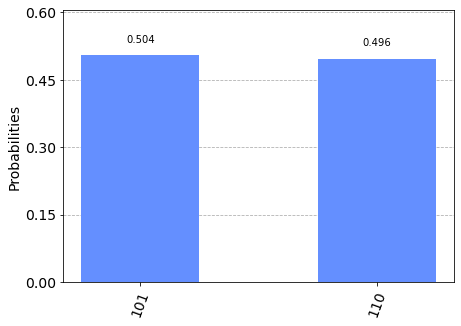

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)